In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.optimize import newton, root
from scipy.interpolate import interp1d
from scipy.integrate import solve_bvp, solve_ivp

from scipy import integrate
from scipy.stats import linregress
import pandas as pd

import time
plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['legend.fontsize'] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["figure.titlesize"] = 24
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Obtiene gif de la solución
def get_animation(Q, x, U, Nt, title, titles, path):
    
    # Crea figura
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    ax1, ax2, ax3 = axs
    
    # Parámetros
    plt.xlabel(r'$x$')
    plt.ylabel(r'$Q(t, x)$')
    ax1.set_title(titles[0])
    ax2.set_title(title[1])
    
    fig.suptitle(title)
    
    ax1.set_ylim(-0.1, 0.8)
    ax2.set_ylim(-1, 60)
    ax3.set_ylim(-10, 20)
    
    ax1.set_xlabel("x")
    ax2.set_xlabel("x")
    ax3.set_ylabel("x")
    
    # Valores iniciales
    rho_0 = Q[0][0]
    y_0 = Q[0][1]
    u_0 = u(rho_0, y_0, U)
    U_eq_0 = U(rho_0)

    # Lineas iniciales
    line1, = ax1.plot(x, rho_0, '-', color='r', linewidth=2)
    line2, = ax2.plot(x, u_0, '-', color='b', linewidth=2, label=r"u")
    line3, = ax3.plot(x, U_eq_0, '-', color='g', linewidth=2)
    
    plt.legend()

    def animate(n):
        
        # Instante n
        rho = Q[n][0]
        y = Q[n][1]
        u_ = u(rho, y, U)
        U_eq = U(rho)
        
        # Actualiza gráfico
        line1.set_ydata(rho)
        line2.set_ydata(u_)
        line3.set_ydata(U_eq)

        ax1.set_title(titles[0])
        ax2.set_title(titles[1])
        ax3.set_title(titles[2])
        
        return [line1, line2, line3]

    ani = animation.FuncAnimation(fig, animate, np.arange(0, Nt, 3),
                                interval=50, blit=True)

    ani.save(path)

# Aplicación a ecuación ARZ

Se toma el modelo ARZ no homogeneo, que considera conservación de masa y del campo de velocidades shifteado. Las ecuaciones corresponden a
$$
\begin{align*}
\rho_t + (\rho u)_x &= 0\\
(u - U(\rho))_t + u(u-U(\rho))_x &= \frac{(U(\rho) - u)}{\tau}
\end{align*}
$$

donde $\rho = \rho(x, t)$ corresponde a la densidad vehicular, $u=u(x, t)$ al campo de velocidades y $U(\rho)$ velocidad de equilibrio. Consideraremos $U(\rho) = u_{\text{max}}(1-\rho^\gamma)$ con $\gamma \in (0, 1)$. En particular, se usarán $u_{\text{max}}=20$ y $\gamma=1/2$.

Definiendo $y(\rho, u)= \rho(u-U(\rho))$ y sumando ambas ecuaciones, podemos escribir el sistema en su forma conservativa:
$$
 \textbf{Q}_t + F( \textbf{Q})_x = \textbf{S}(y, \rho)
$$
donde $ \textbf{Q} = \begin{pmatrix} \rho \\ y \end{pmatrix}$, $F(\textbf{Q}) = \begin{pmatrix} \rho u\\ yu\end{pmatrix}$ y $ \textbf{S}(y, u) = \begin{pmatrix} 0 \\ -\frac{y}{\rho} \end{pmatrix}$. De esta forma se puede utilizar cualquier esquema de volúmenes finitos que se haya visto. En este caso, se usará el esquema de Godunov, que pide resolver el problema de Riemann asociado al modelo. Este se resolverá analiticamente y se programará separando en casos.

Una opción a manejar es resolver el problema de Riemann usando solvers aproximadores, pues se puede complejizar más si se resuelve el problema de Riemann no homogeneo. Se puede también resolver analíticamente pero resulta en un mayor coste computacional.

## Funciones del modelo

In [12]:
beta = 8
gamma = 1/2
u_max = 20
rho_max = 1/7.5
c = 0.078 * u_max * rho_max
b = 1/3
l = 1/10

# Define u en función de rho e y
def u(rho, y, h):
    output = y/rho - h(rho)
    return output


# Define y en función de rho y u
def y_u(rho, u, h):
    output = rho*(u + h(rho))
    return output


# Flujo del modelo
def flux(Q, h):
    
    # Rescata variables
    rho, y = Q

    return np.array([y-rho*h(rho), (y**2)/rho - h(rho)*y]) #np.array([rho * u_, y * u_])



# Flujo con HLL
def F_HLL_old(Q, N, U, h):

    # Guarda flujo en un arreglo
    F_ = np.zeros(Q.shape)

    def phi(r):
        r_1, r_2 = r
        output_1 = np.max([0, np.min([1, r_1])])
        output_2 = np.max([0, np.min([1, r_2])])
        output = np.array([output_1, output_2])
        return output

    for i in range(1, N-1):
        
        # Rescata actual y vecinos
        Q_left = Q[:, i-1]
        Q_i = Q[:, i]
        Q_right = Q[:, i+1]

        # Evalúa en el flujo HLL
        F_[:, i] = flux_HLL(Q_i, Q_right, h) - flux_HLL(Q_left, Q_i, h)

    # Asume condiciones de borde periódicas
    Q_0 = Q[:, 0]
    Q_1 = Q[:, 1]
    Q_ult = Q[:, -1]
    Q_pen = Q[:, -2]

    per = flux_HLL(Q_0, Q_1, h) - flux_HLL(Q_pen, Q_ult, h)
    F_[:, 0] = per
    F_[:, -1] = per

    return F_



# Flujo con HLL
def F_HLL(Q, N, U, h):

    # Guarda flujo en un arreglo
    F_ = np.zeros(Q.shape)

    def phi(r):
        r_1, r_2 = r
        output_1 = np.max([0, np.min([1, r_1])])
        output_2 = np.max([0, np.min([1, r_2])])
        output = np.array([output_1, output_2])
        return output

    for i in range(2, N-2):
        
        # Rescata actual y vecinos
        Q_left_left = Q[:, i-2]
        Q_left = Q[:, i-1]
        Q_i = Q[:, i]
        Q_right = Q[:, i+1]
        Q_right_right = Q[:, i+2]

        r_left = (Q_left - Q_left_left)/(Q_i - Q_left)
        r_i = (Q_i - Q_left)/(Q_right - Q_i)
        r_right = (Q_right - Q_i)/(Q_right_right - Q_right)

        Q_L = Q_i + (1/2) * phi(r_i) * (Q_right - Q_i)
        Q_L_ = Q_left + (1/2) * phi(r_left) * (Q_i - Q_left)

        Q_R = Q_right - (1/2) * phi(r_right) * (Q_right_right - Q_right)
        Q_R_ = Q_i - (1/2) * phi(r_i) * (Q_right - Q_i)


        # Evalúa en el flujo HLL
        F_[:, i] = flux_HLL(Q_L, Q_R, h) - flux_HLL(Q_L_, Q_R_, h) #flux_HLL(Q_i, Q_right, h) - flux_HLL(Q_left, Q_i, h)

    # Asume condiciones de borde periódicas
    Q_0 = Q[:, 0]
    Q_1 = Q[:, 1]
    Q_2 = Q[:, 2]
    Q_3 = Q[:, 3]
    Q_ult = Q[:, -1]
    Q_pen = Q[:, -2]
    Q_antp = Q[:, -3]
    Q_antantp = Q[:, -4]
    
    # i = 1
    r_0 = (Q_ult - Q_pen)/(Q_1 - Q_ult)
    r_1 = (Q_1 - Q_0)/(Q_2 - Q_1)
    r_2 = (Q_2 - Q_1)/(Q_3 - Q_2)

    Q_L_1 = Q_1 + (1/2) * phi(r_1) * (Q_2 - Q_1)
    Q_L_1_ = Q_ult + (1/2) * phi(r_0) * (Q_1 - Q_ult)

    Q_R_1 = Q_2 - (1/2) * phi(r_2) * (Q_3 - Q_2)
    Q_R_1_ = Q_1 - (1/2) * phi(r_1) * (Q_2 - Q_1)

    per_1 = flux_HLL(Q_L_1, Q_R_1, h) - flux_HLL(Q_L_1_, Q_R_1_, h)


    # i = 0
    r_left = (Q_pen - Q_antp)/(Q_ult - Q_pen)
    r_0 = (Q_ult - Q_pen)/(Q_1 - Q_ult)
    r_right = (Q_1 - Q_0)/(Q_2 - Q_1)

    Q_L_0 = Q_ult + (1/2) * phi(r_0) * (Q_1 - Q_ult)
    Q_L_0_ = Q_pen + (1/2) * phi(r_left) * (Q_ult - Q_pen)

    Q_R_0 = Q_1 - (1/2) * phi(r_right) * (Q_2 - Q_1)
    Q_R_0_ = Q_ult - (1/2) * phi(r_0) * (Q_1 - Q_ult)

    per = flux_HLL(Q_L_0, Q_R_0, h) - flux_HLL(Q_L_0_, Q_R_0_, h)

    # i = N-1
    r_antp = (Q_antp - Q_antantp)/(Q_pen - Q_antp)
    r_pen = (Q_pen - Q_antp)/(Q_ult - Q_pen)
    r_ult = (Q_ult - Q_pen)/(Q_1 - Q_ult)

    Q_L_N_1 = Q_pen + (1/2) * phi(r_pen) * (Q_ult - Q_pen)
    Q_L_N_1_ = Q_antp + (1/2) * phi(r_antp) * (Q_pen - Q_antp)

    Q_R_N_1 = Q_ult - (1/2) * phi(r_ult) * (Q_1 - Q_ult)
    Q_R_N_1_ = Q_pen - (1/2) * phi(r_pen) * (Q_ult - Q_pen)

    per_2 = flux_HLL(Q_L_N_1, Q_R_N_1, h) - flux_HLL(Q_L_N_1_, Q_R_N_1_, h)
    
    F_[:, 1] = per_1
    F_[:, 0] = per
    F_[:, -1] = per
    F_[:, -2] = per_2

    return F_


# Funciones del modelo
# Función de duda
def h(rho):
    if type(rho) is float or type(rho) is np.float64:
        rho = np.array(rho)

    return beta*(rho/(rho_max-rho))**gamma


# Integral de densidad
def density_integral(x, dx, N_t, Q):
    integral_graph = []
    for n in range(N_t):
    
        density = Q[n, 0, :]
        integral = integrate.simpson(density, x, dx)
        integral_graph += [integral]
    return integral_graph


def h_prime(rho):
    output =  beta * gamma * (rho /(rho_max - rho))**(gamma-1) * rho_max / ((rho_max - rho)**2)
    return output


# Función g
def g(y):
    output = np.sqrt(1 + ((y-b)/l)**2)
    return output


# Diagrama fundamental
def Q_e(rho):
    output = c * (g(0) + (((g(1) - g(0)) * rho/rho_max)) - g(rho/rho_max))
    return output


# Derivada de g
def g_prime(y):
    output = (1/l**2) * ((y-b)/ np.sqrt(1 + ((y-b)/l)**2)) 
    return output


# Derivada de Q
def Q_prime(rho):
    output = c * (((g(1) - g(0))/rho_max) - (g_prime(rho/rho_max)/rho_max))
    return output


# Velocidad de equilibrio
def U(rho):
    output = Q_e(rho)/(np.sqrt((rho**2 + 1e-5**2)))
    return output


# Derivada de la velocidad de equilibrio
def U_prime(rho):
    output = (Q_prime(rho) - U(rho))/np.sqrt((rho**2 + 1e-5**2))
    return output


# Inversa de U
def U_inv_points(z):
    z = float(z)
    U_to_inv = lambda x: U(x)-z

    rho = np.real(root(U_to_inv, 0.5*rho_max).x[0])
    return rho

zs_U = np.linspace(u_max, 0, 50)
U_inv_to_poly = [U_inv_points(z) for z in zs_U]

U_inv = interp1d(zs_U, U_inv_to_poly)


# Inversa de la derivada de Q
def Q_p_inv_points(z):
    z = float(z)
    Q_to_inv = lambda x: Q_prime(x)-z
    
    rho = np.real(root(Q_to_inv, 0.3*rho_max).x[0])
    return rho

zs_Q = np.linspace(-2, u_max, 50)
Q_p_inv_to_poly = [Q_p_inv_points(z) for z in zs_Q]

Q_p_inv = interp1d(zs_Q, Q_p_inv_to_poly)


# Solver HLL para riemann
def flux_HLL(Q_l, Q_r, h):
    # Rescata variables a la izquierda
    rho_l, y_l = Q_l

    # Rescata variables a la derecha
    rho_r, y_r = Q_r

    # Obtiene velocidades
    u_l = u(rho_l, y_l, h)
    u_r = u(rho_r, y_r, h)

    l_1_l = u_r - rho_r * h_prime(rho_r)
    l_1_r = u_l - rho_l * h_prime(rho_l)
    l_2_l = u_l
    l_2_r = u_r

    s_l = np.min([l_1_l, l_1_r])
    s_r = np.max([l_2_l, l_2_r])

    s_R_plus = np.max([s_r, 0])
    s_l_minus = np.min([s_l, 0])

    F_l = flux(Q_l, h)
    F_r = flux(Q_r, h)

    F_hat = (s_R_plus * F_l - s_l_minus * F_r + s_l_minus * s_R_plus * (Q_r - Q_l))/(s_R_plus - s_l_minus)
    return F_hat


# Obtiene velocidad de onda máxima
def get_s_max():
    rho_s_zero = root(lambda rho: U_prime(rho) + h_prime(rho), 0.2*rho_max).x[0]
    v_s_zero = 1/rho_s_zero
    m_max = -h_bar_prime(v_s_zero)
    s_max = U_bar(v_s_zero) - m_max * v_s_zero
    return s_max


# Condición CFL
def cfl(dx):
    s_max = get_s_max()

    # Podría dar problemas
    new_dt = dx/(2*s_max) #dx/(2*u_max) #dx/(2*(u_max + np.max([-Q_prime(rho_max), I_plus]))) #

    return new_dt


In [13]:
############################### Variables lagrangeanas #########################################

# Funciones del modelo
def h_bar(v):
    return h(1/v)


def h_bar_prime(v):
    output = -h_prime(1/v)/v**2 
    return output


def U_bar(v):
    return U(1/v)


def w_v(v, m, s):
    output = U_bar(v) - (m * v + s)
    return output


def r(v, m):
    output = m * h_bar(v) + m**2 * v
    return output


def r_prime(v, m):
    output = m * h_bar_prime(v) + m**2
    return output


def ode_jam_v(x, v, tau, m, s):
    output = w_v(v, m, s)/(r_prime(v, m) * v * tau)
    return output


def ode_jam_v_eta(eta, v, m, s):
    output = w_v(v, m, s)/(r_prime(v, m) * v)
    return output

## Resuelve el problema de Riemann

In [14]:
# Implementa Godunov
def godunov_ARZ(Q_0, N, x, U, h, tau, T, F):
    
    # Largo de la grilla
    L = x[-1] - x[0]

    # salto espacial
    dx = L/N
    
    
    # Guarda soluciones
    # Condición inicial
    
    Q = np.zeros([1, 2, N])
    Q[0][0] = Q_0[0]
    Q[0][1] = Q_0[1]
    
    # Actualiza segun condicion CFL
    dt = cfl(dx)
    #dt = 0
    t = 0
    n = 0
    t_list = [t]
    
    while t < T:
        
        l = dt/dx
        
        # Paso de Godunov
        Q_sig = Q[n] - l * F(Q[n], N, U, h)
        
        # Agrega no homogeneidad
        rho_sig, y_sig = Q_sig
        
        # Resuelve termino de relajación
        alpha = dt/tau

        # Implícito
        y_sig_ = (alpha/(1+alpha)) * rho_sig * (U(rho_sig) + h(rho_sig)) + (1/(1+alpha)) * y_sig
        Q_sig[1] = y_sig_
        
        #Q_sig[:, -1] = Q_sig[:, 0]
        
        # Guarda paso
        Q_sig = np.reshape(Q_sig, (1, Q_sig.shape[0], Q_sig.shape[1]))
        Q = np.append(Q, Q_sig, axis=0)

        # Actualiza indice y tiempo
        n += 1
        t += dt
        t_list += [t]
        
    return x, dt, t_list, Q

## Generador de jamitones

In [15]:
# Resuelve EDO con respecto a x
def ODE_jam_solve(t_f, v_R, tau, m, s):
    # Resuelve EDO
    sol_v = solve_ivp(ode_jam_v, (0, t_f), [v_R], t_eval=np.linspace(0, t_f, 10_000), args=[tau, m, s], dense_output=True)
    return sol_v

# Resuelve EDO con respecto a eta
def ODE_jam_solve_eta(eta_f, v_R, m, s):
    # Resuelve EDO
    sol_v = solve_ivp(ode_jam_v_eta, (0, eta_f), [v_R], t_eval=np.linspace(0, eta_f, 10_000), args=[m, s], dense_output=True)
    return sol_v

In [16]:
# Encuentra xs importantes
def find_xs(sol_v, values_v, rho_s, x_init=None):

    # Rescata valores de v
    v_s = values_v["v_s"]
    v_minus = values_v["v_minus"]
    v_plus = values_v["v_plus"]
    
    #if x_init is None:
    #    if 0.24 < rho_s < 0.45:
    #        x_init = 0

    #    if 0.45 <= rho_s < 0.6:
    #        x_init = 90

    #    else:
    #        x_init = 250
    x_init = 0
    # Calcula cada x
    x_minus = root(lambda v: sol_v.sol(v)[0] - v_minus, 20).x[0]
    x_plus = root(lambda v: sol_v.sol(v)[0] - v_plus, 0).x[0]
    x_s = root(lambda v: sol_v.sol(v)[0] - v_s, 0).x[0]
    x_to_plot = sol_v.t
    x_to_per = np.linspace(x_minus, sol_v.t[-1], 500)

    return x_to_plot, x_minus, x_plus, x_s, x_to_per


# Genera jamitones
def jam_gen(v_s, t_f, tau, v_minus):

    values_v = {}
    values_rho = {}
    values_u = {}

    # Parámetros del jamiton
    m = -h_bar_prime(v_s)
    s = U_bar(v_s) - m * v_s

    # Imprime parámetros
    #print("Velocidad jamiton: ", s)
    #print("m= ", m)

    # Existencia jamiton
    jam_exs = U_prime(v_to_rho(v_s)) + h_prime(v_to_rho(v_s)) < 0
    if not jam_exs:
        print("No existe jamiton, pruebe otro valor de rho_s")
        return None

    # Jamiton maximal
    v_M = root(lambda v: w_v(v, m, s), 40).x[0]
    v_R = root(lambda v: r(v, m) - r(v_M, m), 10).x[0]

    # Jamiton actual
    #v_minus = float(input("Escoja v_min (entre {vs} y {vM}): ".format(vs =round(v_s, 3), vM=round(v_M, 3))))
    v_plus = root(lambda v: r(v, m) - r(v_minus, m), 8).x[0]

    # Guarda valores de v
    values_v["v_s"] = v_s
    values_v["v_M"] = v_M
    values_v["v_R"] = v_R
    values_v["v_minus"] = v_minus
    values_v["v_plus"] = v_plus

    # Guarda valores de rho
    values_rho["rho_s"] = v_to_rho(v_s)
    values_rho["rho_M"] = v_to_rho(v_M)
    values_rho["rho_R"] = v_to_rho(v_R)
    values_rho["rho_minus"] = v_to_rho(v_minus)
    values_rho["rho_plus"] = v_to_rho(v_plus)

    # Guarda valores de u
    values_u["u_s"] = rho_to_u(values_rho["rho_s"], m, s)
    values_u["u_M"] = rho_to_u(values_rho["rho_M"], m, s)
    values_u["u_R"] = rho_to_u(values_rho["rho_R"], m, s)
    values_u["u_minus"] = rho_to_u(values_rho["rho_minus"], m, s)
    values_u["u_plus"] = rho_to_u(values_rho["rho_plus"], m, s)

    # Solucion EDO
    sol_v = ODE_jam_solve(t_f, v_R, tau, m, s)
    sol_rho = lambda x: v_to_rho(sol_v.sol(x)[0])
    sol_u = lambda x: rho_to_u(sol_rho(x), m, s)

    return values_v, values_rho, values_u, sol_v, sol_rho, sol_u, m, s

# Transforma v a rho
def v_to_rho(v):
    rho = 1/v
    return rho

# Transforma rho a u
def rho_to_u(rho, m, s):
    u = (m/rho) + s
    return u

# Inicia programa
def init_program(tau, rho_s, v_minus, x_init=None):
    v_f = 100
    t_f = 6000

    # Elección valores sónicos
    rho_s *= rho_max
    v_s = 1/rho_s # Se necesita rho_s normalizado

    # Genera jamitones
    values_v, values_rho, values_u, sol_v, sol_rho, sol_u, m, s = jam_gen(v_s, t_f, tau, v_minus)

    # Resuelve para eta
    sol_v_eta = ODE_jam_solve_eta(t_f, values_v["v_R"], m, s)
    sol_rho_eta = lambda eta: v_to_rho(sol_v_eta.sol(eta)[0])
    sol_u_eta = lambda eta: rho_to_u(sol_rho_eta(eta), m, s)

    # Rescata x's
    xs = find_xs(sol_v, values_v, rho_s, x_init)
    x_minus = xs[1]
    x_plus = xs[2]

    # Arreglo con jamiton
    x_jam = np.linspace(x_plus, x_minus, 100)
    return x_minus, x_plus, sol_rho, sol_u, sol_rho_eta, sol_u_eta, s

## Condiciones iniciales

In [17]:
# Condición inicial jamiton
def Q_0_jam(h, N, tau, rho_s, v_minus, x_init=None):

    x_minus, x_plus, sol_rho, sol_u, sol_rho_eta, sol_u_eta, s = init_program(tau, rho_s, v_minus, x_init)
    L = np.fabs(x_minus-x_plus)

    #print("x_+: ", x_plus)
    #print("x_-: ", x_minus)
    #print("Largo del intervalo: ", L)
    dx = L/N  
    x_to_plot = np.arange(0, L, dx)

    def rho_per(x):
        interval = x_minus - x_plus
        x_per = (x - x_plus) % interval + x_plus
        return sol_rho(x_per)

    def u_per(x):
        interval = x_minus - x_plus
        x_per = (x - x_minus) % interval + x_plus
        return sol_u(x_per)
    
    rho_0 = rho_per(x_to_plot)
    u_0 = u_per(x_to_plot)
    y_0 = rho_0 * (u_0 + h(rho_0))

    Q_0_ = np.zeros([2, N])
    Q_0_[0] = rho_0
    Q_0_[1] = y_0

    def teo_rho(x, t, s=s):
        eta_minus = x_minus / tau
        eta_plus = x_plus / tau
        eta = (x - s*t)/tau
        interval = eta_minus - eta_plus
        eta_per = (eta - eta_plus) % interval + eta_plus

        return sol_rho_eta(eta_per)

    def teo_u(x, t, s=s):
        eta_minus = x_minus / tau
        eta_plus = x_plus / tau
        eta = (x - s*t)/tau
        interval = eta_minus - eta_plus
        eta_per = (eta - eta_plus) % interval + eta_plus

        return sol_u_eta(eta_per)

    return Q_0_, x_to_plot, teo_rho, teo_u

In [18]:
rho_s = 0.433
v_minus = 26

tau = 5
T = 2
N = 160

Q_0_, x_to_plot, teo_rho, teo_u = Q_0_jam(h, N, tau, rho_s, v_minus)
x, dt, t, Q = godunov_ARZ(Q_0_, N, x_to_plot, U, h, tau, T, F_HLL_old)

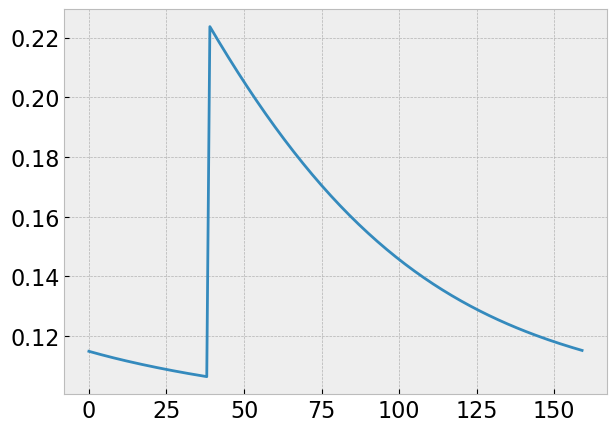

In [23]:
plt.plot(Q[0][-1]*rho_max)

/var/folders/41/vskcwr5532bfb2q1wpk9q40h0000gn/T/ipykernel_2335/838023127.py:177: DeprecationWarning: You are passing x=[ 0.          0.24174425  0.4834885   0.72523274  0.96697699  1.20872124
  1.45046549  1.69220973  1.93395398  2.17569823  2.41744248  2.65918672
  2.90093097  3.14267522  3.38441947  3.62616372  3.86790796  4.10965221
  4.35139646  4.59314071  4.83488495  5.0766292   5.31837345  5.5601177
  5.80186195  6.04360619  6.28535044  6.52709469  6.76883894  7.01058318
  7.25232743  7.49407168  7.73581593  7.97756017  8.21930442  8.46104867
  8.70279292  8.94453717  9.18628141  9.42802566  9.66976991  9.91151416
 10.1532584  10.39500265 10.6367469  10.87849115 11.1202354  11.36197964
 11.60372389 11.84546814 12.08721239 12.32895663 12.57070088 12.81244513
 13.05418938 13.29593362 13.53767787 13.77942212 14.02116637 14.26291062
 14.50465486 14.74639911 14.98814336 15.22988761 15.47163185 15.7133761
 15.95512035 16.1968646  16.43860885 16.68035309 16.92209734 17.16384159
 17.40

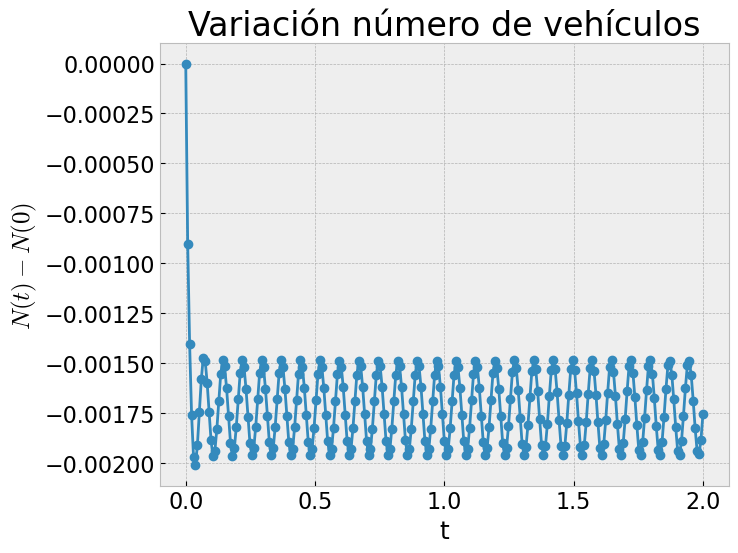

In [19]:
L = x[-1] - x[0]
t_to_plot = np.linspace(0, T, len(Q))
dx = L/N
integral_col = density_integral(x, dx, len(Q), Q)
plt.plot(t_to_plot, integral_col - integral_col[0], "o-")
plt.tight_layout()
plt.title("Variación número de vehículos")
plt.xlabel("t")
plt.ylabel(r"$N(t) - N(0)$")
#plt.ylim(2.07, 2.08)

#plt.savefig("Charts/Jamitones/integral_densidad.png", dpi=300, bbox_inches = "tight")
plt.show()

In [19]:
def error_L1(x, t, dt, Q, rho_teo, u_teo):
    i = int(t//dt)
    error_rho = np.linalg.norm(Q[i][0] - rho_teo(x, t), ord=1)
    u_sim = u(Q[i][0], Q[i][1], h)
    u_teo_error = u_teo(x, t)
    error_u = np.linalg.norm(u_sim - u_teo_error, ord=1)
    
    norm_teo_rho = np.linalg.norm(rho_teo(x, t), ord=1)
    norm_teo_u = np.linalg.norm(u_teo_error, ord=1)
    
    return 100 * error_rho/norm_teo_rho, 100 * error_u/norm_teo_u

In [274]:
def obtiene_errores(T, tau, rho_s, v_minus, F, x_init=None):
    Ns = [10*(2**k) for k in range(1, 9)]

    errores_rho = []
    errores_u = []

    for N in Ns:
        Q_0_, x_to_plot, teo_rho, teo_u = Q_0_jam(h, N, tau, rho_s, v_minus, x_init)
        x, dt, t, Q = godunov_ARZ(Q_0_, N, x_to_plot, U, h, tau, T, F)
        error_rho, error_u = error_L1(x, T, dt, Q, teo_rho, teo_u)

        errores_rho += [error_rho]
        errores_u += [error_u]
        
    return errores_rho, errores_u, Ns

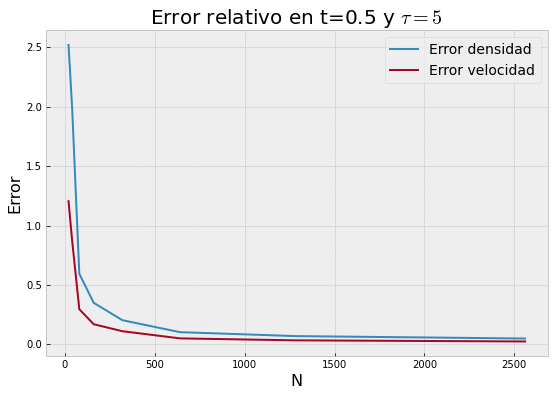

,N,Error rho,Error u
0,20,2.518741,1.204772
1,40,1.991870,0.874195
2,80,0.594136,0.295892
3,160,0.349761,0.169553
4,320,0.203410,0.110920
5,640,0.102964,0.050692
6,1280,0.069952,0.034128
7,2560,0.049420,0.024618


In [22]:
# Primera tanda de errores

rho_s = 0.43
v_minus = 26

tau_1 = 5
T_1 = 0.5

errores_rho_1, errores_u_1, Ns = obtiene_errores(T_1, tau_1, rho_s, v_minus, F_HLL_old)

errores_dic_1 = {"N": Ns, "Error rho": errores_rho_1, "Error u": errores_u_1}
errores_df_1 = pd.DataFrame(data=errores_dic_1)

plt.plot(Ns, errores_rho_1, label="Error densidad")
plt.plot(Ns, errores_u_1, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_1, tau=tau_1))
plt.legend()

plt.savefig("Charts/Errores/Error_1.png")
plt.show()

errores_df_1

In [90]:
error_rho_1 = errores_df_1["Error rho"].to_numpy()
error_u_1 = errores_df_1["Error u"].to_numpy()
N_1 = errores_df_1["N"].to_numpy()

In [113]:
def EOC(ex, ey):
    num = np.log(ex/ey)
    den = np.log(1/2)
    output = num/den
    return output

In [115]:
EOCs_1_rho = []
EOCs_1_u = []
for i in range(1, len(N)):
    
    ey_rho = error_rho_1[i-1]
    ex_rho = error_rho_1[i]

    ey_u = error_u_1[i-1]
    ex_u = error_u_1[i]
    
    EOC_1_rho = EOC(ex_rho, ey_rho)
    EOC_1_u = EOC(ex_u, ey_u)
    
    EOCs_1_rho += [EOC_1_rho]
    EOCs_1_u += [EOC_1_u]

In [116]:
EOC_1_dic = {"EOC rho": EOCs_1_rho, "EOC u": EOCs_1_u}
EOC_1_df = pd.DataFrame(EOC_1_dic)
EOC_1_df

,EOC rho,EOC u
0,0.338579,0.462732
1,1.745258,1.562884
2,0.764424,0.803336
3,0.781977,0.612217
4,0.982249,1.129701
5,0.557708,0.570785
6,0.501265,0.471249


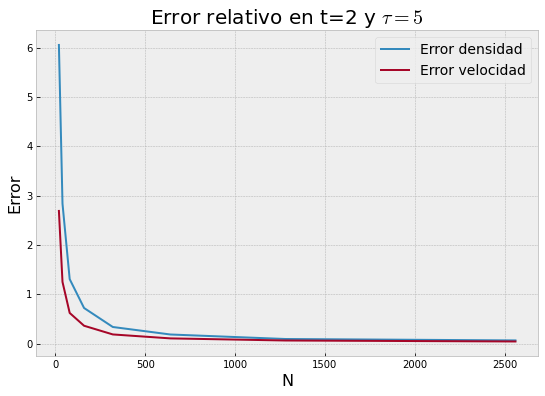

,N,Error rho,Error u
0,20,6.054774,2.690319
1,40,2.836523,1.250834
2,80,1.307742,0.622079
3,160,0.722480,0.362747
4,320,0.337405,0.186556
5,640,0.185509,0.106441
6,1280,0.094001,0.063668
7,2560,0.065307,0.043931


In [23]:
# Segunda tanda de errores

rho_s = 0.43
v_minus = 26

tau_1 = 5
T_2 = 2

errores_rho_2, errores_u_2, Ns = obtiene_errores(T_2, tau_1, rho_s, v_minus, F_HLL_old)

errores_dic_2 = {"N": Ns, "Error rho": errores_rho_2, "Error u": errores_u_2}
errores_df_2 = pd.DataFrame(data=errores_dic_2)

plt.plot(Ns, errores_rho_2, label="Error densidad")
plt.plot(Ns, errores_u_2, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_2, tau=tau_1))
plt.legend()

plt.savefig("Charts/Errores/Error_2.png")
plt.show()

errores_df_2

In [117]:
error_rho_2 = errores_df_2["Error rho"].to_numpy()
error_u_2 = errores_df_2["Error u"].to_numpy()
N_2 = errores_df_2["N"].to_numpy()

In [118]:
EOCs_2_rho = []
EOCs_2_u = []
for i in range(1, len(N)):
    
    ey_rho = error_rho_2[i-1]
    ex_rho = error_rho_2[i]

    ey_u = error_u_2[i-1]
    ex_u = error_u_2[i]
    
    EOC_2_rho = EOC(ex_rho, ey_rho)
    EOC_2_u = EOC(ex_u, ey_u)
    
    EOCs_2_rho += [EOC_2_rho]
    EOCs_2_u += [EOC_2_u]

In [119]:
EOC_2_dic = {"EOC rho": EOCs_2_rho, "EOC u": EOCs_2_u}
EOC_2_df = pd.DataFrame(EOC_2_dic)
EOC_2_df

,EOC rho,EOC u
0,1.093949,1.104887
1,1.117046,1.007720
2,0.856047,0.778135
3,1.098478,0.959356
4,0.862993,0.809554
5,0.980742,0.741421
6,0.525440,0.535317


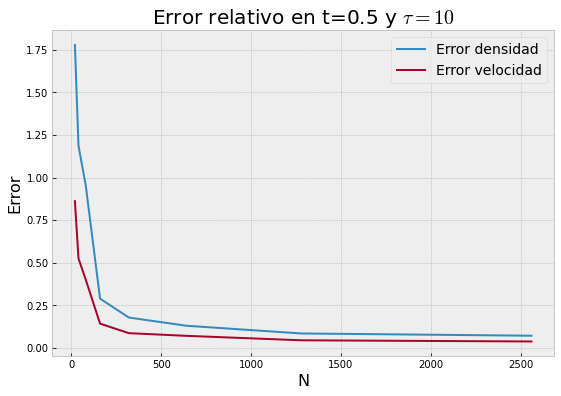

,N,Error rho,Error u
0,20,1.778708,0.862047
1,40,1.186639,0.525577
2,80,0.956746,0.402381
3,160,0.290106,0.143484
4,320,0.179226,0.087517
5,640,0.131014,0.071842
6,1280,0.085735,0.045630
7,2560,0.072517,0.038728


In [24]:
# Tercera tanda de errores

rho_s = 0.43
v_minus = 26

tau_2 = 10
T_3 = 0.5

errores_rho_3, errores_u_3, Ns = obtiene_errores(T_3, tau_2, rho_s, v_minus, F_HLL_old)

errores_dic_3 = {"N": Ns, "Error rho": errores_rho_3, "Error u": errores_u_3}
errores_df_3 = pd.DataFrame(data=errores_dic_3)

plt.plot(Ns, errores_rho_3, label="Error densidad")
plt.plot(Ns, errores_u_3, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_3, tau=tau_2))
plt.legend()

plt.savefig("Charts/Errores/Error_3.png")
plt.show()

errores_df_3

In [120]:
error_rho_3 = errores_df_3["Error rho"].to_numpy()
error_u_3 = errores_df_3["Error u"].to_numpy()
N_3 = errores_df_3["N"].to_numpy()

In [121]:
EOCs_3_rho = []
EOCs_3_u = []
for i in range(1, len(N)):
    
    ey_rho = error_rho_3[i-1]
    ex_rho = error_rho_3[i]

    ey_u = error_u_3[i-1]
    ex_u = error_u_3[i]
    
    EOC_3_rho = EOC(ex_rho, ey_rho)
    EOC_3_u = EOC(ex_u, ey_u)
    
    EOCs_3_rho += [EOC_3_rho]
    EOCs_3_u += [EOC_3_u]

In [122]:
EOC_3_dic = {"EOC rho": EOCs_3_rho, "EOC u": EOCs_3_u}
EOC_3_df = pd.DataFrame(EOC_3_dic)
EOC_3_df

,EOC rho,EOC u
0,0.583949,0.713864
1,0.310673,0.385341
2,1.721556,1.487669
3,0.694797,0.713257
4,0.452061,0.284729
5,0.611771,0.654853
6,0.241557,0.236590


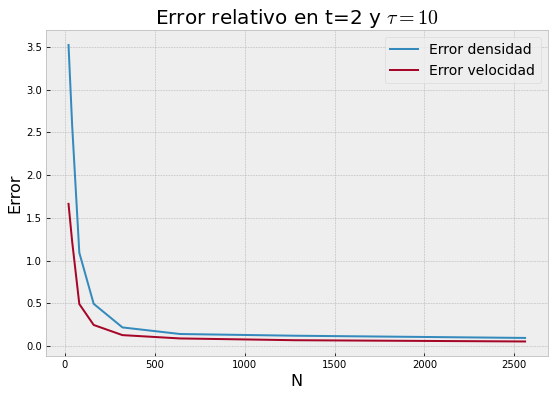

,N,Error rho,Error u
0,20,3.523763,1.663390
1,40,2.589387,1.226214
2,80,1.091665,0.490892
3,160,0.493108,0.245729
4,320,0.217158,0.126986
5,640,0.140062,0.088068
6,1280,0.119894,0.067314
7,2560,0.093973,0.052545


In [25]:
# Cuarta tanda de errores

rho_s = 0.43
v_minus = 26

tau_2 = 10
T_4 = 2

errores_rho_4, errores_u_4, Ns = obtiene_errores(T_4, tau_2, rho_s, v_minus, F_HLL_old)

errores_dic_4 = {"N": Ns, "Error rho": errores_rho_4, "Error u": errores_u_4}
errores_df_4 = pd.DataFrame(data=errores_dic_4)

plt.plot(Ns, errores_rho_4, label="Error densidad")
plt.plot(Ns, errores_u_4, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_4, tau=tau_2))
plt.legend()

plt.savefig("Charts/Errores/Error_4.png")
plt.show()

errores_df_4

In [123]:
error_rho_4 = errores_df_4["Error rho"].to_numpy()
error_u_4 = errores_df_4["Error u"].to_numpy()

In [124]:
EOCs_4_rho = []
EOCs_4_u = []
for i in range(1, len(error_rho_4)):
    
    ey_rho = error_rho_4[i-1]
    ex_rho = error_rho_4[i]

    ey_u = error_u_4[i-1]
    ex_u = error_u_4[i]
    
    EOC_4_rho = EOC(ex_rho, ey_rho)
    EOC_4_u = EOC(ex_u, ey_u)
    
    EOCs_4_rho += [EOC_4_rho]
    EOCs_4_u += [EOC_4_u]

In [125]:
EOC_4_dic = {"EOC rho": EOCs_4_rho, "EOC u": EOCs_4_u}
EOC_4_df = pd.DataFrame(EOC_4_dic)
EOC_4_df

,EOC rho,EOC u
0,0.444506,0.439916
1,1.246081,1.320733
2,1.146555,0.998337
3,1.183156,0.952396
4,0.632680,0.527979
5,0.224309,0.387709
6,0.351446,0.357351


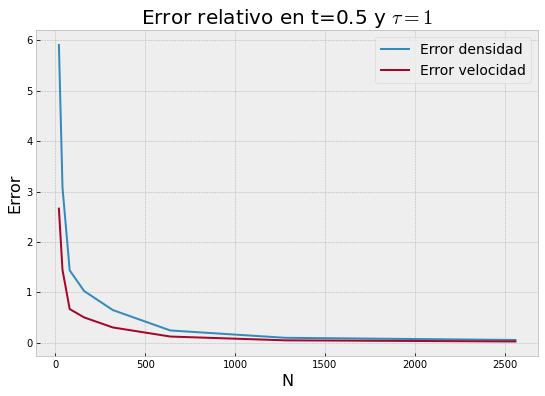

,N,Error rho,Error u
0,20,5.907602,2.660977
1,40,3.079131,1.445140
2,80,1.437231,0.668689
3,160,1.027584,0.503457
4,320,0.648655,0.303979
5,640,0.244117,0.123481
6,1280,0.098586,0.048248
7,2560,0.055397,0.025694


In [26]:
# Quinta tanda de errores

rho_s = 0.43
v_minus = 26

tau_3 = 1
T_5 = 0.5

errores_rho_5, errores_u_5, Ns = obtiene_errores(T_5, tau_3, rho_s, v_minus, F_HLL_old, x_init=100)

errores_dic_5 = {"N": Ns, "Error rho": errores_rho_5, "Error u": errores_u_5}
errores_df_5 = pd.DataFrame(data=errores_dic_5)

plt.plot(Ns, errores_rho_5, label="Error densidad")
plt.plot(Ns, errores_u_5, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_5, tau=tau_3))
plt.legend()

plt.savefig("Charts/Errores/Error_5.png")
plt.show()

errores_df_5

In [126]:
error_rho_5 = errores_df_5["Error rho"].to_numpy()
error_u_5 = errores_df_5["Error u"].to_numpy()

In [127]:
EOCs_5_rho = []
EOCs_5_u = []
for i in range(1, len(error_rho_5)):
    
    ey_rho = error_rho_5[i-1]
    ex_rho = error_rho_5[i]

    ey_u = error_u_5[i-1]
    ex_u = error_u_5[i]
    
    EOC_5_rho = EOC(ex_rho, ey_rho)
    EOC_5_u = EOC(ex_u, ey_u)
    
    EOCs_5_rho += [EOC_5_rho]
    EOCs_5_u += [EOC_5_u]

In [128]:
EOC_5_dic = {"EOC rho": EOCs_5_rho, "EOC u": EOCs_5_u}
EOC_5_df = pd.DataFrame(EOC_5_dic)
EOC_5_df

,EOC rho,EOC u
0,0.940049,0.880747
1,1.099231,1.111802
2,0.484035,0.409467
3,0.663733,0.727898
4,1.409880,1.299685
5,1.308113,1.355746
6,0.831567,0.909039


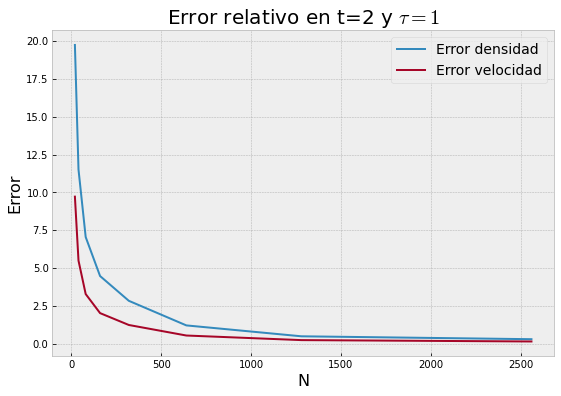

,N,Error rho,Error u
0,20,19.759582,9.725298
1,40,11.521335,5.494746
2,80,7.052434,3.281655
3,160,4.473396,2.020708
4,320,2.834102,1.235218
5,640,1.207457,0.538251
6,1280,0.486751,0.234564
7,2560,0.295068,0.144266


In [27]:
# Sexta tanda de errores

rho_s = 0.43
v_minus = 26

tau_3 = 1
T_6 = 2

errores_rho_6, errores_u_6, Ns = obtiene_errores(T_6, tau_3, rho_s, v_minus, F_HLL_old, x_init=100)

errores_dic_6 = {"N": Ns, "Error rho": errores_rho_6, "Error u": errores_u_6}
errores_df_6 = pd.DataFrame(data=errores_dic_6)

plt.plot(Ns, errores_rho_6, label="Error densidad")
plt.plot(Ns, errores_u_6, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_6, tau=tau_3))
plt.legend()

plt.savefig("Charts/Errores/Error_6.png")
plt.show()

errores_df_6

In [130]:
error_rho_6 = errores_df_6["Error rho"].to_numpy()
error_u_6 = errores_df_6["Error u"].to_numpy()

In [131]:
EOCs_6_rho = []
EOCs_6_u = []
for i in range(1, len(error_rho_6)):
    
    ey_rho = error_rho_6[i-1]
    ex_rho = error_rho_6[i]

    ey_u = error_u_6[i-1]
    ex_u = error_u_6[i]
    
    EOC_6_rho = EOC(ex_rho, ey_rho)
    EOC_6_u = EOC(ex_u, ey_u)
    
    EOCs_6_rho += [EOC_6_rho]
    EOCs_6_u += [EOC_6_u]

In [132]:
EOC_6_dic = {"EOC rho": EOCs_6_rho, "EOC u": EOCs_6_u}
EOC_6_df = pd.DataFrame(EOC_6_dic)
EOC_6_df

,EOC rho,EOC u
0,0.778244,0.823690
1,0.708115,0.743629
2,0.656751,0.699563
3,0.658478,0.710096
4,1.230920,1.198413
5,1.310717,1.198299
6,0.722135,0.701254


## Método con segundo orden de precisión

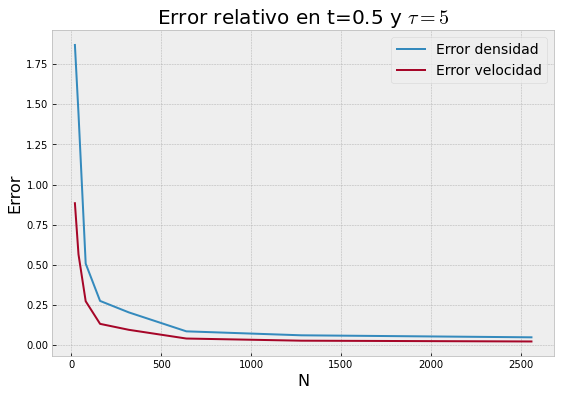

,N,Error rho,Error u
0,20,2.518741,1.204772
1,40,1.991870,0.874195
2,80,0.594136,0.295892
3,160,0.349761,0.169553
4,320,0.203410,0.110920
5,640,0.102964,0.050692
6,1280,0.069952,0.034128
7,2560,0.049420,0.024618


In [282]:
# Primera tanda de errores

rho_s = 0.43
v_minus = 26

tau_1 = 5
T_1 = 0.5

errores_rho_1_mejor, errores_u_1_mejor, Ns = obtiene_errores(T_1, tau_1, rho_s, v_minus, F_HLL)

errores_dic_1_mejor = {"N": Ns, "Error rho": errores_rho_1_mejor, "Error u": errores_u_1_mejor}
errores_df_1_mejor = pd.DataFrame(data=errores_dic_1_mejor)

plt.plot(Ns, errores_rho_1_mejor, label="Error densidad")
plt.plot(Ns, errores_u_1_mejor, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_1, tau=tau_1))
plt.legend()

plt.savefig("Charts/Errores/Error_1_mejor.png")
plt.show()

In [286]:
errores_df_1_mejor

,N,Error rho,Error u
0,20,1.869912,0.883892
1,40,1.441598,0.565055
2,80,0.507521,0.273123
3,160,0.275132,0.132211
4,320,0.203637,0.095097
5,640,0.085593,0.040746
6,1280,0.060884,0.027338
7,2560,0.048326,0.022429


In [287]:
error_rho_1_mejor = errores_df_1_mejor["Error rho"].to_numpy()
error_u_1_mejor = errores_df_1_mejor["Error u"].to_numpy()
N_1 = errores_df_1_mejor["N"].to_numpy()

In [292]:
EOCs_1_rho_mejor = []
EOCs_1_u_mejor = []
for i in range(1, len(N_1)):
    
    ey_rho = error_rho_1_mejor[i-1]
    ex_rho = error_rho_1_mejor[i]

    ey_u = error_u_1_mejor[i-1]
    ex_u = error_u_1_mejor[i]
    
    EOC_1_rho = EOC(ex_rho, ey_rho)
    EOC_1_u = EOC(ex_u, ey_u)
    
    EOCs_1_rho_mejor += [EOC_1_rho]
    EOCs_1_u_mejor += [EOC_1_u]

In [293]:
EOC_1_dic_mejor = {"EOC rho": EOCs_1_rho_mejor, "EOC u": EOCs_1_u_mejor}
EOC_1_df_mejor = pd.DataFrame(EOC_1_dic_mejor)
EOC_1_df_mejor

,EOC rho,EOC u
0,0.375302,0.645478
1,1.506130,1.048839
2,0.883341,1.046714
3,0.434127,0.475361
4,1.250442,1.222755
5,0.491427,0.575747
6,0.333263,0.285542


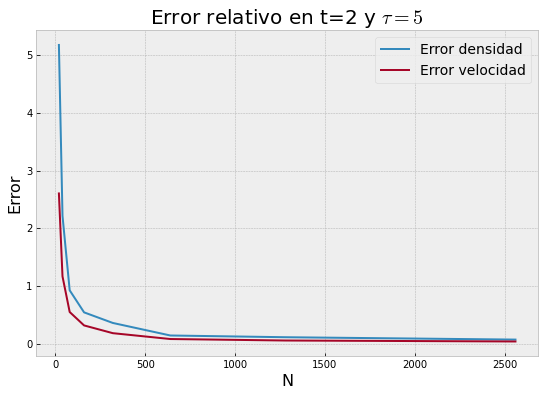

,N,Error rho,Error u
0,20,5.178948,2.606050
1,40,2.218324,1.168919
2,80,0.927723,0.551752
3,160,0.545676,0.319374
4,320,0.362165,0.185023
5,640,0.144898,0.083661
6,1280,0.114898,0.057850
7,2560,0.073799,0.041230


In [294]:
# Segunda tanda de errores

rho_s = 0.43
v_minus = 26

tau_1 = 5
T_2 = 2

errores_rho_2_mejor, errores_u_2_mejor, Ns = obtiene_errores(T_2, tau_1, rho_s, v_minus, F_HLL)

errores_dic_2_mejor = {"N": Ns, "Error rho": errores_rho_2_mejor, "Error u": errores_u_2_mejor}
errores_df_2_mejor = pd.DataFrame(data=errores_dic_2_mejor)

plt.plot(Ns, errores_rho_2_mejor, label="Error densidad")
plt.plot(Ns, errores_u_2_mejor, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_2, tau=tau_1))
plt.legend()

plt.savefig("Charts/Errores/Error_2_mejor.png")
plt.show()

errores_df_2_mejor

In [295]:
error_rho_2_mejor = errores_df_2_mejor["Error rho"].to_numpy()
error_u_2_mejor = errores_df_2_mejor["Error u"].to_numpy()
N_2 = errores_df_2_mejor["N"].to_numpy()

In [297]:
EOCs_2_rho_mejor = []
EOCs_2_u_mejor = []
for i in range(1, len(N_2)):
    
    ey_rho = error_rho_2_mejor[i-1]
    ex_rho = error_rho_2_mejor[i]

    ey_u = error_u_2_mejor[i-1]
    ex_u = error_u_2_mejor[i]
    
    EOC_2_rho = EOC(ex_rho, ey_rho)
    EOC_2_u = EOC(ex_u, ey_u)
    
    EOCs_2_rho_mejor += [EOC_2_rho]
    EOCs_2_u_mejor += [EOC_2_u]

In [298]:
EOC_2_dic_mejor = {"EOC rho": EOCs_2_rho_mejor, "EOC u": EOCs_2_u_mejor}
EOC_2_df_mejor = pd.DataFrame(EOC_2_dic_mejor)
EOC_2_df_mejor

,EOC rho,EOC u
0,1.223189,1.156690
1,1.257704,1.083084
2,0.765648,0.788773
3,0.591399,0.787542
4,1.321612,1.145076
5,0.334684,0.532238
6,0.638677,0.488641


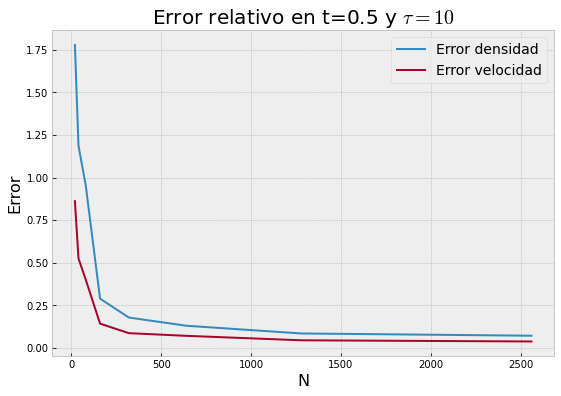

,N,Error rho,Error u
0,20,1.778708,0.862047
1,40,1.186639,0.525577
2,80,0.956746,0.402381
3,160,0.290106,0.143484
4,320,0.179226,0.087517
5,640,0.131014,0.071842
6,1280,0.085735,0.045630
7,2560,0.072517,0.038728


In [24]:
# Tercera tanda de errores

rho_s = 0.43
v_minus = 26

tau_2 = 10
T_3 = 0.5

errores_rho_3, errores_u_3, Ns = obtiene_errores(T_3, tau_2, rho_s, v_minus, F_HLL_old)

errores_dic_3 = {"N": Ns, "Error rho": errores_rho_3, "Error u": errores_u_3}
errores_df_3 = pd.DataFrame(data=errores_dic_3)

plt.plot(Ns, errores_rho_3, label="Error densidad")
plt.plot(Ns, errores_u_3, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_3, tau=tau_2))
plt.legend()

plt.savefig("Charts/Errores/Error_3.png")
plt.show()

errores_df_3

In [120]:
error_rho_3 = errores_df_3["Error rho"].to_numpy()
error_u_3 = errores_df_3["Error u"].to_numpy()
N_3 = errores_df_3["N"].to_numpy()

In [121]:
EOCs_3_rho = []
EOCs_3_u = []
for i in range(1, len(N)):
    
    ey_rho = error_rho_3[i-1]
    ex_rho = error_rho_3[i]

    ey_u = error_u_3[i-1]
    ex_u = error_u_3[i]
    
    EOC_3_rho = EOC(ex_rho, ey_rho)
    EOC_3_u = EOC(ex_u, ey_u)
    
    EOCs_3_rho += [EOC_3_rho]
    EOCs_3_u += [EOC_3_u]

In [122]:
EOC_3_dic = {"EOC rho": EOCs_3_rho, "EOC u": EOCs_3_u}
EOC_3_df = pd.DataFrame(EOC_3_dic)
EOC_3_df

,EOC rho,EOC u
0,0.583949,0.713864
1,0.310673,0.385341
2,1.721556,1.487669
3,0.694797,0.713257
4,0.452061,0.284729
5,0.611771,0.654853
6,0.241557,0.236590


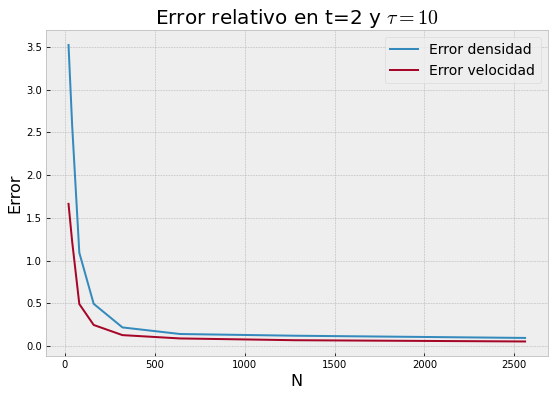

,N,Error rho,Error u
0,20,3.523763,1.663390
1,40,2.589387,1.226214
2,80,1.091665,0.490892
3,160,0.493108,0.245729
4,320,0.217158,0.126986
5,640,0.140062,0.088068
6,1280,0.119894,0.067314
7,2560,0.093973,0.052545


In [25]:
# Cuarta tanda de errores

rho_s = 0.43
v_minus = 26

tau_2 = 10
T_4 = 2

errores_rho_4, errores_u_4, Ns = obtiene_errores(T_4, tau_2, rho_s, v_minus, F_HLL_old)

errores_dic_4 = {"N": Ns, "Error rho": errores_rho_4, "Error u": errores_u_4}
errores_df_4 = pd.DataFrame(data=errores_dic_4)

plt.plot(Ns, errores_rho_4, label="Error densidad")
plt.plot(Ns, errores_u_4, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_4, tau=tau_2))
plt.legend()

plt.savefig("Charts/Errores/Error_4.png")
plt.show()

errores_df_4

In [123]:
error_rho_4 = errores_df_4["Error rho"].to_numpy()
error_u_4 = errores_df_4["Error u"].to_numpy()

In [124]:
EOCs_4_rho = []
EOCs_4_u = []
for i in range(1, len(error_rho_4)):
    
    ey_rho = error_rho_4[i-1]
    ex_rho = error_rho_4[i]

    ey_u = error_u_4[i-1]
    ex_u = error_u_4[i]
    
    EOC_4_rho = EOC(ex_rho, ey_rho)
    EOC_4_u = EOC(ex_u, ey_u)
    
    EOCs_4_rho += [EOC_4_rho]
    EOCs_4_u += [EOC_4_u]

In [125]:
EOC_4_dic = {"EOC rho": EOCs_4_rho, "EOC u": EOCs_4_u}
EOC_4_df = pd.DataFrame(EOC_4_dic)
EOC_4_df

,EOC rho,EOC u
0,0.444506,0.439916
1,1.246081,1.320733
2,1.146555,0.998337
3,1.183156,0.952396
4,0.632680,0.527979
5,0.224309,0.387709
6,0.351446,0.357351


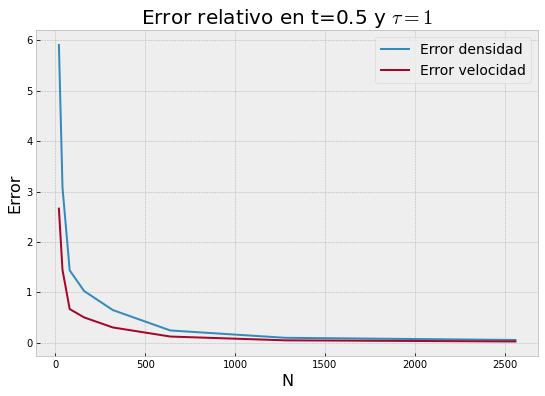

,N,Error rho,Error u
0,20,5.907602,2.660977
1,40,3.079131,1.445140
2,80,1.437231,0.668689
3,160,1.027584,0.503457
4,320,0.648655,0.303979
5,640,0.244117,0.123481
6,1280,0.098586,0.048248
7,2560,0.055397,0.025694


In [26]:
# Quinta tanda de errores

rho_s = 0.43
v_minus = 26

tau_3 = 1
T_5 = 0.5

errores_rho_5, errores_u_5, Ns = obtiene_errores(T_5, tau_3, rho_s, v_minus, F_HLL_old, x_init=100)

errores_dic_5 = {"N": Ns, "Error rho": errores_rho_5, "Error u": errores_u_5}
errores_df_5 = pd.DataFrame(data=errores_dic_5)

plt.plot(Ns, errores_rho_5, label="Error densidad")
plt.plot(Ns, errores_u_5, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_5, tau=tau_3))
plt.legend()

plt.savefig("Charts/Errores/Error_5.png")
plt.show()

errores_df_5

In [126]:
error_rho_5 = errores_df_5["Error rho"].to_numpy()
error_u_5 = errores_df_5["Error u"].to_numpy()

In [127]:
EOCs_5_rho = []
EOCs_5_u = []
for i in range(1, len(error_rho_5)):
    
    ey_rho = error_rho_5[i-1]
    ex_rho = error_rho_5[i]

    ey_u = error_u_5[i-1]
    ex_u = error_u_5[i]
    
    EOC_5_rho = EOC(ex_rho, ey_rho)
    EOC_5_u = EOC(ex_u, ey_u)
    
    EOCs_5_rho += [EOC_5_rho]
    EOCs_5_u += [EOC_5_u]

In [128]:
EOC_5_dic = {"EOC rho": EOCs_5_rho, "EOC u": EOCs_5_u}
EOC_5_df = pd.DataFrame(EOC_5_dic)
EOC_5_df

,EOC rho,EOC u
0,0.940049,0.880747
1,1.099231,1.111802
2,0.484035,0.409467
3,0.663733,0.727898
4,1.409880,1.299685
5,1.308113,1.355746
6,0.831567,0.909039


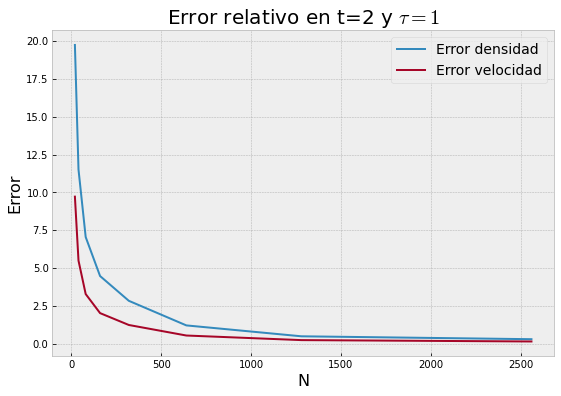

,N,Error rho,Error u
0,20,19.759582,9.725298
1,40,11.521335,5.494746
2,80,7.052434,3.281655
3,160,4.473396,2.020708
4,320,2.834102,1.235218
5,640,1.207457,0.538251
6,1280,0.486751,0.234564
7,2560,0.295068,0.144266


In [27]:
# Sexta tanda de errores

rho_s = 0.43
v_minus = 26

tau_3 = 1
T_6 = 2

errores_rho_6, errores_u_6, Ns = obtiene_errores(T_6, tau_3, rho_s, v_minus, F_HLL_old, x_init=100)

errores_dic_6 = {"N": Ns, "Error rho": errores_rho_6, "Error u": errores_u_6}
errores_df_6 = pd.DataFrame(data=errores_dic_6)

plt.plot(Ns, errores_rho_6, label="Error densidad")
plt.plot(Ns, errores_u_6, label="Error velocidad")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo en t={T} y $\tau={tau}$".format(T=T_6, tau=tau_3))
plt.legend()

plt.savefig("Charts/Errores/Error_6.png")
plt.show()

errores_df_6

In [130]:
error_rho_6 = errores_df_6["Error rho"].to_numpy()
error_u_6 = errores_df_6["Error u"].to_numpy()

In [131]:
EOCs_6_rho = []
EOCs_6_u = []
for i in range(1, len(error_rho_6)):
    
    ey_rho = error_rho_6[i-1]
    ex_rho = error_rho_6[i]

    ey_u = error_u_6[i-1]
    ex_u = error_u_6[i]
    
    EOC_6_rho = EOC(ex_rho, ey_rho)
    EOC_6_u = EOC(ex_u, ey_u)
    
    EOCs_6_rho += [EOC_6_rho]
    EOCs_6_u += [EOC_6_u]

In [132]:
EOC_6_dic = {"EOC rho": EOCs_6_rho, "EOC u": EOCs_6_u}
EOC_6_df = pd.DataFrame(EOC_6_dic)
EOC_6_df

,EOC rho,EOC u
0,0.778244,0.823690
1,0.708115,0.743629
2,0.656751,0.699563
3,0.658478,0.710096
4,1.230920,1.198413
5,1.310717,1.198299
6,0.722135,0.701254


## Obtiene velocidad jamiton

In [9]:
def get_m(v_s):
    m = -h_bar_prime(v_s)
    return m

def get_s(m, v_s):
    s = U_bar(v_s) - m*v_s
    return s

In [10]:
def get_s_least_squares(Q):

    rho, y = Q[-1]
    
    u_ = u(rho, y, h)
    q = rho * u_

    res = linregress(rho, q)
    s, m = res[0], res[1]
    return s, m

In [11]:
def obtiene_errores_s(Ns, T, tau, rho_s, v_minus, F, x_init=None):
    
    v_s = 1/(rho_s * rho_max)

    errores_s = []
    errores_m = []

    for N in Ns:
        Q_0_, x_to_plot, teo_rho, teo_u = Q_0_jam(h, N, tau, rho_s, v_minus, x_init)
        x, dt, t, Q = godunov_ARZ(Q_0_, N, x_to_plot, U, h, tau, T, F)
        s, m = get_s_least_squares(Q)
        
        # Teoricos
        m_teo = get_m(v_s)
        s_teo = get_s(m_teo, v_s)
        
        dif_s = np.fabs(s_teo - s)/np.fabs(s_teo)
        dif_m = np.fabs(m_teo - m)/np.fabs(m_teo)

        errores_s += [dif_s]
        errores_m += [dif_m]
        
    return errores_s, errores_m

In [12]:
get_s(get_m(1/(0.433*rho_max)), 1/(0.433*rho_max))

6.373851586874937

In [13]:
rho_s = 0.43
v_s = 1/(rho_s*rho_max)
v_minus = 26

tau = 5
T = 2
N = 400

Q_0_, x_to_plot, teo_rho, teo_u = Q_0_jam(h, N, tau, rho_s, v_minus)
x, dt, t, Q = godunov_ARZ(Q_0_, N, x_to_plot, U, h, tau, T)

TypeError: godunov_ARZ() missing 1 required positional argument: 'F'

In [14]:
# Primera tanda de errores para s y m

Ns = [10*(2**k) for k in range(1, 9)]

rho_s = 0.43
v_minus = 26

tau_1 = 5
T_1 = 2

s_1, m_1 = obtiene_errores_s(Ns, T_1, tau_1, rho_s, v_minus, F_HLL_old)

errores_sm_1 = {"N": Ns, "Error s": s_1, "Error m": m_1}
errores_sm_df_1 = pd.DataFrame(data=errores_sm_1)

plt.plot(Ns, s_1, label="Error s")
plt.plot(Ns, m_1, label="Error m")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo de s y m en t={T} y $\tau={tau}$".format(T=T_1, tau=tau_1))
plt.legend()

#plt.savefig("Charts/Errores/Error_sm_1.png")
plt.show()

errores_sm_df_1

TypeError: F_HLL_old() missing 1 required positional argument: 'dx'

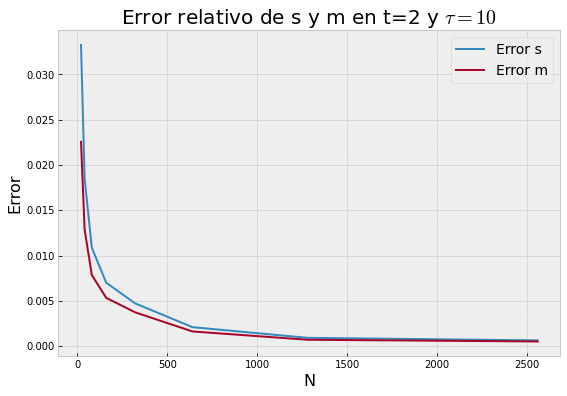

,N,Error s,Error m
0,20,0.033255,0.022553
1,40,0.018492,0.012862
2,80,0.010867,0.007853
3,160,0.007006,0.005328
4,320,0.004729,0.003738
5,640,0.002091,0.001618
6,1280,0.000914,0.000702
7,2560,0.000629,0.000511


In [33]:
# Segunda tanda de errores para s y m

tau_2 = 10

s_2, m_2 = obtiene_errores_s(Ns, T_1, tau_2, rho_s, v_minus, F_HLL_old)

errores_sm_2 = {"N": Ns, "Error s": s_2, "Error m": m_2}
errores_sm_df_2 = pd.DataFrame(data=errores_sm_2)

plt.plot(Ns, s_2, label="Error s")
plt.plot(Ns, m_2, label="Error m")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo de s y m en t={T} y $\tau={tau}$".format(T=T_1, tau=tau_2))
plt.legend()

plt.savefig("Charts/Errores/Error_sm_2.png")
plt.show()

errores_sm_df_2

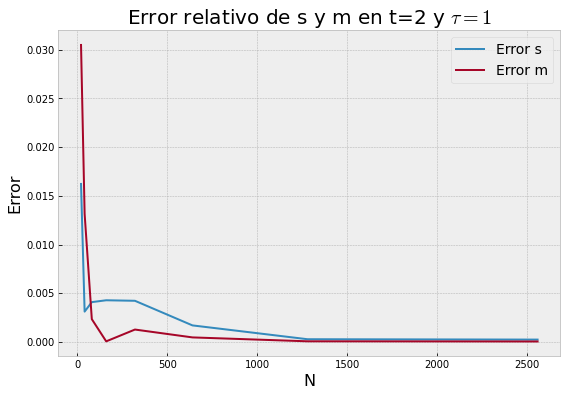

,N,Error s,Error m
0,20,0.016227,0.030492
1,40,0.003123,0.013156
2,80,0.004097,0.002350
3,160,0.004288,0.000071
4,320,0.004234,0.001282
5,640,0.001708,0.000476
6,1280,0.000289,0.000076
7,2560,0.000251,0.000058


In [34]:
# Tercera tanda de errores para s y m

tau_3 = 1

s_3, m_3 = obtiene_errores_s(Ns, T_1, tau_3, rho_s, v_minus, F_HLL_old, x_init=100)

errores_sm_3 = {"N": Ns, "Error s": s_3, "Error m": m_3}
errores_sm_df_3 = pd.DataFrame(data=errores_sm_3)

plt.plot(Ns, s_3, label="Error s")
plt.plot(Ns, m_3, label="Error m")

plt.xlabel("N")
plt.ylabel("Error")
plt.title(r"Error relativo de s y m en t={T} y $\tau={tau}$".format(T=T_1, tau=tau_3))
plt.legend()

plt.savefig("Charts/Errores/Error_sm_3.png")
plt.show()

errores_sm_df_3

----------------------------------

## Colisión de jamitones

In [15]:
def Q_0_collide(h, N, tau, rho_s_1, rho_s_2, v_minus, x_init=None):
    # Primer jamiton
    x_minus_1, x_plus_1, sol_rho_1, sol_u_1, sol_rho_eta_1, sol_u_eta_1, s_1 = init_program(tau, rho_s_1, v_minus, x_init)

    # Segundo jamiton
    x_minus_2, x_plus_2, sol_rho_2, sol_u_2, sol_rho_eta_2, sol_u_eta_2, s_2 = init_program(tau, rho_s_2, v_minus, x_init)

    # Jamitones compatibles
    rho_min_1 = sol_rho_1(x_minus_1)
    rho_min_2 = sol_rho_2(x_minus_2)

    compatible = np.isclose(rho_min_1, rho_min_2)

    if not compatible:
        print(rho_min_1, rho_min_2)
        print("Jamitones incompatibles")
        return None

    L = x_minus_2 + (x_minus_1 - x_plus_2) - x_plus_1
    dx = L/N
    
    x_to_plot = np.arange(0, x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1, dx)

    def rho_sol_combined(x):
        if x_plus_1 <= x and x <= x_minus_1:
            return sol_rho_1(x)
    
        elif x_plus_2 <= x - (x_minus_1 - x_plus_2) and x - (x_minus_1 - x_plus_2) <= x_minus_2:
            return sol_rho_2(x-(x_minus_1 - x_plus_2))

    def u_sol_combined(x):
        if x_plus_1 <= x and x <= x_minus_1:
            return sol_u_1(x)
    
        elif x_plus_2 <= x - (x_minus_1 - x_plus_2) and x - (x_minus_1 - x_plus_2) <= x_minus_2:
            return sol_u_2(x-(x_minus_1 - x_plus_2))

    rho_sol_combined = np.vectorize(rho_sol_combined)
    u_sol_combined = np.vectorize(u_sol_combined)

    def rho_per(x):
        interval = x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1
        x_per = (x - x_plus_1) % interval + x_plus_1
        return rho_sol_combined(x_per)

    def u_per(x):
        interval = x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1
        x_per = (x - x_plus_1) % interval + x_plus_1
        return u_sol_combined(x_per)

    rho_0 = rho_per(x_to_plot)
    u_0 = u_per(x_to_plot)
    y_0 = rho_0 * (u_0 + h(rho_0))

    Q_0_ = np.zeros([2, len(x_to_plot)])
    Q_0_[0] = rho_0
    Q_0_[1] = y_0
    
    return Q_0_, x_to_plot

In [16]:
N = 160
tau = 5
rho_s_1 = 0.425
rho_s_2 = 0.443
v_minus = 25
T = 10

Q_0_collide_, x_collide = Q_0_collide(h, N, tau, rho_s_1, rho_s_2, v_minus)

ti = time.time()
x, dt, t, Q = godunov_ARZ(Q_0_collide_, N, x_collide, U, h, tau, T, F_HLL)
tf = time.time()
print("Tiempo de ejecución: ",tf - ti)

Tiempo de ejecución:  43.55178189277649


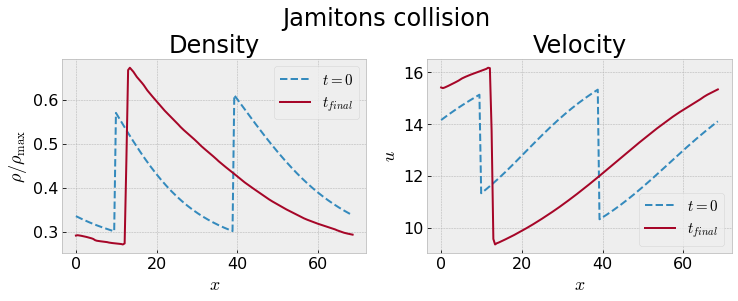

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle("Jamitons collision")
fig.subplots_adjust(top=0.8)

axs[0].plot(x_collide, Q[0][0]/rho_max, label=r"$t=0$", ls="--")
axs[0].plot(x_collide, Q[-20][0]/rho_max, label=r"$t_{final}$")
axs[0].set_title("Density")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel(r"$\rho/\rho_{\max}$")

u_init = u(Q[0][0], Q[0][1], h)
u_final = u(Q[-20][0], Q[-20][1], h)

axs[1].plot(x_collide, u_init, label=r"$t=0$", ls="--")
axs[1].plot(x_collide, u_final, label=r"$t_{final}$")
axs[1].set_title("Velocity")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$u$")

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
plt.savefig("Charts/Colisiones/Ejemplo_colision_english.png", dpi=300, bbox_inches = "tight")
plt.show()

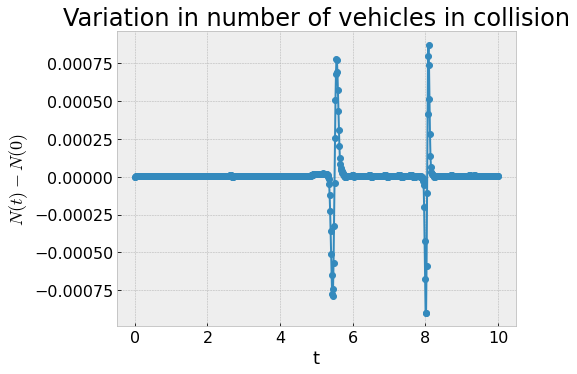

In [18]:
L = x[-1] - x[0]
t_to_plot = np.linspace(0, T, len(Q))
dx = L/N
integral_col = density_integral(x, dx, len(Q), Q)
plt.plot(t_to_plot, integral_col-integral_col[0], "o-")

plt.title("Variation in number of vehicles in collision")
plt.tight_layout()
plt.xlabel("t")
plt.ylabel(r"$N(t)-N(0)$")
#plt.ylim(3.6, 4)

plt.savefig("Charts/Colisiones/Integral_densidad_english.png", dpi=300, bbox_inches = "tight")
plt.show()

In [19]:
v_s_1 = 1/(rho_s_1*rho_max)
v_s_2 = 1/(rho_s_2*rho_max)

m_1 = get_m(v_s_1)
m_2 = get_m(v_s_2)

s_1 = get_s(m_1, v_s_1)
s_2 = get_s(m_2, v_s_2)

s_1, s_2, m_1, m_2

(6.901298483049857, 5.711643574447141, 0.33890685707962004, 0.3782870937959668)

In [20]:
s_post, m_post = get_s_least_squares(Q)

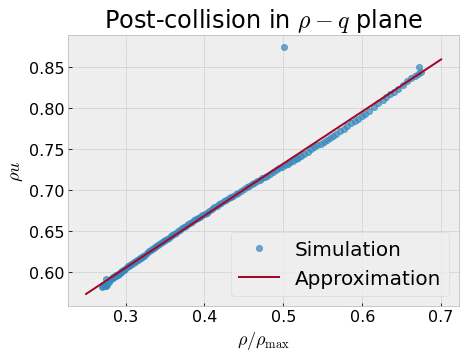

In [21]:
rho_sc = Q[-1][0]
u_sc = u(rho_sc, Q[-1][1], h)

rho_to_plot = np.linspace(0.25*rho_max, 0.7*rho_max, 1000)

plt.plot(rho_sc/rho_max, rho_sc*u_sc, "o", alpha=.7, label="Simulation")
plt.plot(rho_to_plot/rho_max, s_post*rho_to_plot + m_post, label="Approximation")
plt.legend()

plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$\rho u$")
plt.title(r"Post-collision in $\rho - q$ plane")
plt.savefig("Charts/Colisiones/segmento_english.png", dpi=300, bbox_inches = "tight")
plt.show()

## N-colisión

In [22]:
def Q_0_N_collide(h, N, tau, rho_s_1, rho_s_2, v_minus, N_jam, x_init=None):
    # Primer jamiton
    x_minus_1, x_plus_1, sol_rho_1, sol_u_1, sol_rho_eta_1, sol_u_eta_1, s_1 = init_program(tau, rho_s_1, v_minus, x_init)

    # Segundo jamiton
    x_minus_2, x_plus_2, sol_rho_2, sol_u_2, sol_rho_eta_2, sol_u_eta_2, s_2 = init_program(tau, rho_s_2, v_minus, x_init)

    # Jamitones compatibles
    rho_min_1 = sol_rho_1(x_minus_1)
    rho_min_2 = sol_rho_2(x_minus_2)

    compatible = np.isclose(rho_min_1, rho_min_2)

    if not compatible:
        print(rho_min_1, rho_min_2)
        print("Jamitones incompatibles")
        return None

    L = x_minus_2 + (x_minus_1 - x_plus_2) - x_plus_1
    dx = L/N
    
    x_to_plot = np.arange(0, x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1, dx) #np.arange(0, x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1, dx)

    def rho_sol_combined(x):
        if x_plus_1 <= x and x <= x_minus_1:
            return sol_rho_1(x)
    
        elif x_plus_2 <= x - (x_minus_1 - x_plus_2) and x - (x_minus_1 - x_plus_2) <= x_minus_2:
            return sol_rho_2(x-(x_minus_1 - x_plus_2))

    def u_sol_combined(x):
        if x_plus_1 <= x and x <= x_minus_1:
            return sol_u_1(x)
    
        elif x_plus_2 <= x - (x_minus_1 - x_plus_2) and x - (x_minus_1 - x_plus_2) <= x_minus_2:
            return sol_u_2(x-(x_minus_1 - x_plus_2))

    rho_sol_combined = np.vectorize(rho_sol_combined)
    u_sol_combined = np.vectorize(u_sol_combined)

    def rho_per(x):
        interval = x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1
        x_per = (x - x_plus_1) % interval + x_plus_1
        return rho_sol_combined(x_per)

    def u_per(x):
        interval = x_minus_2+(x_minus_1 - x_plus_2) - x_plus_1
        x_per = (x - x_plus_1) % interval + x_plus_1
        return u_sol_combined(x_per)

    rho_0 = rho_per(x_to_plot)
    u_0 = u_per(x_to_plot)
    y_0 = rho_0 * (u_0 + h(rho_0))

    Q_0_ = np.zeros([2, len(x_to_plot)])
    Q_0_[0] = rho_0
    Q_0_[1] = y_0
    
    return Q_0_, x_to_plot

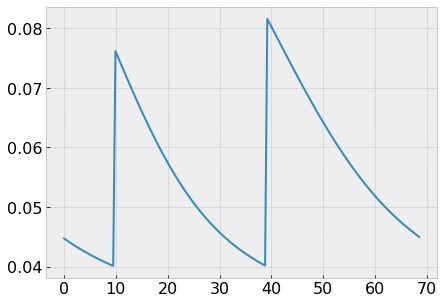

In [23]:
Q_0_collide_, x_collide = Q_0_N_collide(h, N, tau, rho_s_1, rho_s_2, v_minus, 0)
plt.plot(x_collide, Q_0_collide_[0])
plt.show()

## Obtiene $\rho_s$ candidatos

In [24]:
rho_min_css = root(lambda rho: U_prime(rho) + h_prime(rho), 0.2*rho_max, method="lm")
rho_min_css

   cov_x: array([[1.57549059e-08]])
    fjac: array([[7966.95004056]])
     fun: array([-1.84741111e-13])
    ipvt: array([1], dtype=int32)
 message: 'The relative error between two consecutive iterates is at most 0.000000'
    nfev: 11
     qtf: array([8.74162254e-09])
  status: 2
 success: True
       x: array([0.03151071])

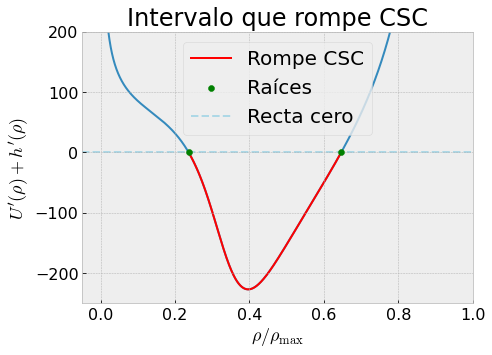

In [25]:
rhos = np.linspace(1e-8, rho_max-1e-5, 10_000)
rho_min_scc = root(lambda rho: U_prime(rho) + h_prime(rho), 0.1*rho_max, method="lm").x[0]
rho_max_scc = root(lambda rho: U_prime(rho) + h_prime(rho), 0.7*rho_max, method="lm").x[0]
raices_scc = np.array([rho_min_scc, rho_max_scc])
rhos_violate = np.linspace(rho_min_scc, rho_max_scc, 10_000)

plt.plot(rhos/rho_max, U_prime(rhos) + h_prime(rhos), zorder=0)
plt.plot(rhos_violate/rho_max, U_prime(rhos_violate) + h_prime(rhos_violate), zorder=1, label="Rompe CSC", color="r")
plt.scatter(raices_scc/rho_max, U_prime(raices_scc) + h_prime(raices_scc), zorder=2, color="green", label="Raíces")

plt.xlim(-0.05, 1)
plt.ylim(-250, 200)
plt.hlines(0, -0.05, 1, ls="--", zorder=1, label="Recta cero", color="lightblue")

plt.title("Intervalo que rompe CSC")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$U'(\rho) + h'(\rho)$")

plt.legend()
plt.savefig("Charts/Funciones/Rompe_SCC.png", dpi=300, bbox_inches = "tight")
plt.show()

In [26]:
print("Intervalo [",rho_min_scc/rho_max,rho_max_scc/rho_max, "] rompe SCC")

Intervalo [ 0.23633033494494432 0.6467412717332214 ] rompe SCC


In [27]:
rhos_violate = np.linspace(rho_min_scc+1e-8, rho_max_scc-1e-8, 20_000)
def obtiene_mejor_rho_s():
    L = -np.inf
    for i in range(len(rhos_violate)):
        rho_scc = rhos_violate[i]
        v_scc = 1/rho_scc
        m_scc = get_m(v_scc)
        s_scc = get_s(m_scc, v_scc)
        w_scc = lambda v: w_v(v, m_scc, s_scc)
        v_M = root(w_scc, 100, method="hybr")
        L_sig = v_M.x[0] - v_scc

        if L_sig < L:
            print("Intervalo v_min: [", v_scc, ", ", v_M.x[0], "]")
            v_medio = (v_scc + v_M.x[0])/2
            print("Valor medio: ", v_medio)
            return rho_scc, i, v_medio
        L = L_sig
rho_s_test, i_test, v_medio_test = obtiene_mejor_rho_s()
#v_medio_test = 30

Intervalo v_min: [ 17.307528367266812 ,  35.89639363220734 ]
Valor medio:  26.601960999737077


In [26]:
rho_s_test/rho_max

0.4333374379547178

In [28]:
rhos_candidatos = np.delete(rhos_violate, i_test)
rhos_to_test = []

for j in range(len(rhos_candidatos)):
    rho_cand = rhos_candidatos[j]
    v_cand = 1/rho_cand
    m_cand = get_m(v_cand)
    s_cand = get_s(m_cand, v_cand)
    w_cand = lambda v: w_v(v, m_cand, s_cand)
    v_M_cand = root(w_cand, 100, method="hybr")
    
    if v_cand < v_medio_test and v_medio_test < v_M_cand.x[0]:
        rhos_to_test += [rho_cand]

rhos_to_test = np.array(rhos_to_test)

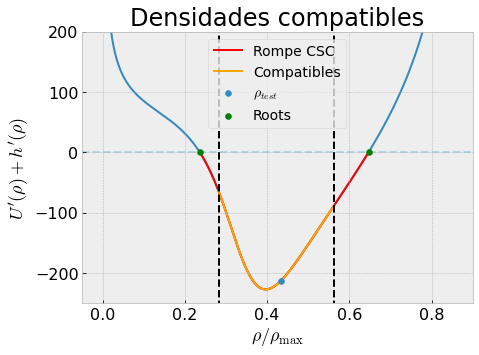

In [31]:
raices_scc = np.array([rho_min_scc, rho_max_scc])
rhos_violate = np.linspace(rho_min_scc, rho_max_scc, 10_000)

plt.plot(rhos/rho_max, U_prime(rhos) + h_prime(rhos), zorder=0)
plt.plot(rhos_violate/rho_max, U_prime(rhos_violate) + h_prime(rhos_violate), zorder=1, label="Rompe CSC", color="r")
plt.plot(rhos_to_test/rho_max, U_prime(rhos_to_test) + h_prime(rhos_to_test), zorder=1, label="Compatibles", color="orange")
plt.scatter(rho_s_test/rho_max, U_prime(rho_s_test) + h_prime(rho_s_test), zorder=2, label=r"$\rho_{test}$")
plt.scatter(raices_scc/rho_max, U_prime(raices_scc) + h_prime(raices_scc), zorder=2, color="green", label="Roots")

plt.xlim(-0.05, 0.9)
plt.ylim(-250, 200)
plt.hlines(0, -0.05, 1, ls="--", zorder=1, color="lightblue")
plt.vlines(rhos_to_test[0]/rho_max, -1750, 200, ls="--", color="black")
plt.vlines(rhos_to_test[-1]/rho_max, -1750, 200, ls="--", color="black")

plt.title("Densidades compatibles")
plt.xlabel(r"$\rho/\rho_{\max}$")
plt.ylabel(r"$U'(\rho) + h'(\rho)$")

plt.legend(fontsize=14)
plt.savefig("Charts/Funciones/Compatibles.png", dpi=300, bbox_inches = "tight")
plt.show()